In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pathlib, os, glob
import tempfile
import numpy as np
import pyarrow.dataset as ds
from dask import delayed
from fastparquet import ParquetFile
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import dask
#import graphviz
#%load_ext line_profiler
client = Client(n_workers=8, threads_per_worker=4, memory_limit='1GB')
dask.config.set({"optimization.fuse.active": False})
client

/Users/chadi/opt/miniconda3/envs/covidSP/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62889 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:62890 Dashboard: http://127.0.0.1:62889/status,Cluster Workers: 8 Cores: 32 Memory: 8.00 GB


In [4]:
geodata = pd.read_csv('state_analysis/USA-20201111T151226/data/geodata_territories_2019.csv',
                     converters={'geoid': lambda x: str(x)})

In [2]:
geodata = pd.read_csv('state-runs/USA-20210112T163155/data/geodata_territories_2019_statelevel.csv',
                     converters={'geoid': lambda x: str(x)})

In [3]:
max_f = -1
path = r'state-runs/bad/hosp/USA/inference/med/2021.01.12.16:31:54./global/intermediate/' # use your path
#path = r'CA/intermediate' # use your path
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]
print(len(file_list))

44


In [4]:
truth = pd.read_csv('state-runs/USA-20210112T163155/data/us_data.csv', 
                    parse_dates=True, 
                    index_col =  'date', 
                    converters={'FIPS': lambda x: str(x)})
truth = truth.groupby(['source', 'date']).sum().reset_index()#.set_index('date', drop=True)
truth = truth.drop(['cumConfirmed', 'cumDeaths'], axis = 1)
truth.columns  = [ 'state','time', 'incidC_T', 'incidD_T']
truth.head()

,state,time,incidC_T,incidD_T
0,AK,2020-01-22,0,0
1,AK,2020-01-23,0,0
2,AK,2020-01-24,0,0
3,AK,2020-01-25,0,0
4,AK,2020-01-26,0,0


In [9]:
df_csv = pq.read_table(file_list[0]).to_pandas()
repeat = int(len(df_csv)/len( geodata))
state_append = geodata['USPS'].repeat(repeat).values

In [6]:
def read_label_prof():
    for i in range(10):
        df_csv = pq.read_table(file_list[i]).to_pandas()
        df_csv['slot'] = int(file_list[0].split('/')[-1].split('.')[0])
        df_csv['sim'] = int(file_list[0].split('/')[-1].split('.')[1])
        df_csv['state'] = state_append
        df_csv = df_csv.drop('geoid', axis = 1)
        df_csv = df_csv.groupby(['state', 'time']).sum().reset_index()#.set_index('time', drop=True)
        df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
        df_csv = pd.merge(df_csv, truth, on=['time', 'state'], how='inner')
    return df_csv

%lprun -f read_label_prof read_label_prof()

Timer unit: 1e-06 s

Total time: 4.62675 s
File: <ipython-input-6-cf6403c68037>
Function: read_label_prof at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def read_label_prof():
     2        11         25.0      2.3      0.0      for i in range(10):
     3        10    1123024.0 112302.4     24.3          df_csv = pq.read_table(file_list[i]).to_pandas()
     4        10      40685.0   4068.5      0.9          df_csv['slot'] = int(file_list[0].split('/')[-1].split('.')[0])
     5        10      41599.0   4159.9      0.9          df_csv['sim'] = int(file_list[0].split('/')[-1].split('.')[1])
     6        10      65961.0   6596.1      1.4          df_csv['state'] = state_append
     7        10    1094026.0 109402.6     23.6          df_csv = df_csv.drop('geoid', axis = 1)
     8        10    2004029.0 200402.9     43.3          df_csv = df_csv.groupby(['state', 'time']).sum().reset_index()#.set_index('time', drop

In [18]:
#@dask.delayed
def read_and_label_hosp(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()             
    df_csv = df_csv[df_csv['p_comp']==0.]
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['state'] = df_csv['geoid']#state_append
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['state', 'time', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
    #df_csv = pd.merge(df_csv, truth, on=['time', 'state'], how='inner')
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_hosp)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)

In [ ]:
ddf['errorC_abs'] = np.abs((ddf['incidC'] - ddf['incidC_T']))
ddf['errorC_rel'] = np.abs((ddf['incidC'] - ddf['incidC_T'])/ddf['incidC_T'])
ddf = ddf.replace([np.inf, -np.inf], np.nan)

In [19]:
post = ddf.groupby(['sim','slot','state']).mean().compute(scheduler="threads")  #much faster than scheduler="processes" and other alternatives #ddf = client.persist(ddf), client.compute, 

In [9]:
#ddf.visualize(rankdir='LR')

In [20]:
post =  post.reorder_levels(['state','slot','sim']).sort_index().reset_index()

In [21]:
post

,state,slot,sim,incidC
0,01000,1,1,678.164814
1,01000,1,2,2712.853610
2,01000,1,3,2712.853610
3,01000,1,4,1268.500964
4,01000,1,5,1268.500964
...,...,...,...,...
2415,78000,8,5,13.807733
2416,78000,9,1,0.736758
2417,78000,9,2,28.609294
2418,78000,9,3,46.274719


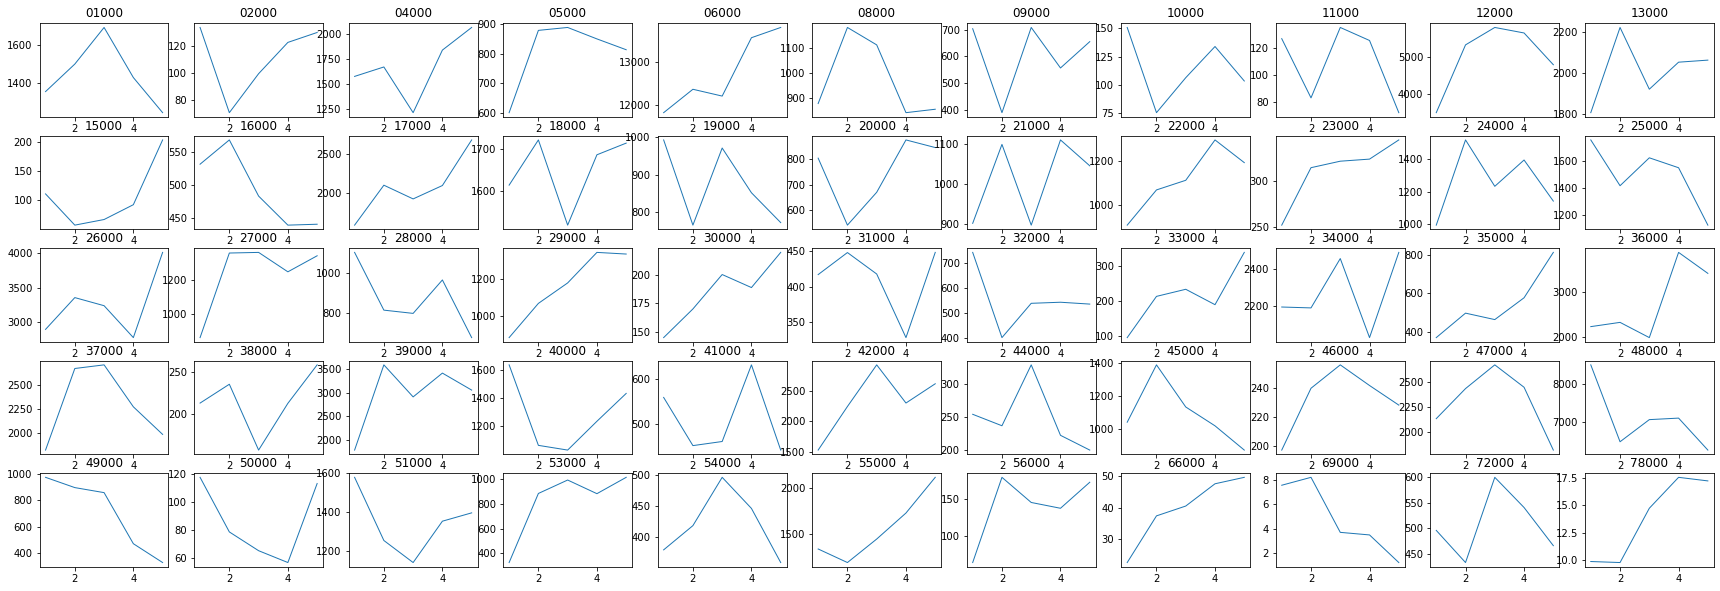

In [22]:
fig, axes = plt.subplots(5,11, figsize=(30,10))

for i, ax in enumerate(axes.flat):
    sn = post['state'].unique()[i]
    st = post[post['state'] == sn].pivot(index='sim', columns='slot', values='incidC')
    #ax.plot(st, lw = .5)
    #ax.plot(st.quantile(.5, axis = 1), lw = 1)
    ax.plot(st.mean(axis = 1), lw = 1)#, marker = '.')
    ax.set_title(sn)
    #ax.set_ylim(0,1000)

In [ ]:
full = post.groupby(['sim', 'slot']).sum().reset_index()

full.pivot(index='sim', columns='slot', values='errorC_rel').plot(legend=False)
full.pivot(index='sim', columns='slot', values='errorC_abs').plot(legend=False)
#post.to_csv('USA-20201109T013836-hosp.csv')

In [15]:
max_f = 5

file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]

def read_and_label_CA(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['state'] = 'CA'
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['state', 'time', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
    df_csv = pd.merge(df_csv, truth[truth['state']=='CA'], on=['time', 'state'], how='inner')
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfsS = [delayed(read_and_label_CA)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfS = dd.from_delayed(dfsS)

In [16]:
ddfS['errorC_abs'] = np.abs((ddfS['incidC'] - ddfS['incidC_T']))
ddfS['errorC_rel'] = np.abs((ddfS['incidC'] - ddfS['incidC_T'])/ddfS['incidC_T'])
ddfS = ddfS.replace([np.inf, -np.inf], np.nan)

In [17]:
postS = ddfS.groupby(['sim','slot','state']).mean().compute(scheduler="threads") 

In [18]:
postS =  postS.reorder_levels(['state','slot','sim']).sort_index().reset_index()

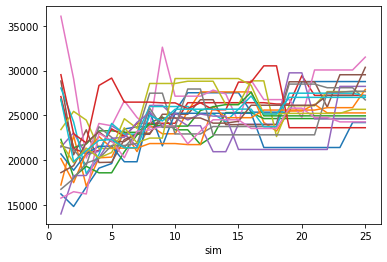

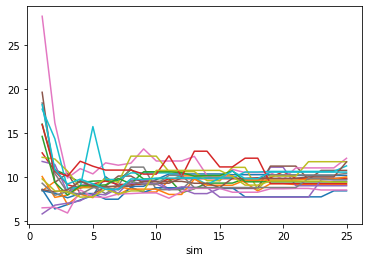

In [19]:
postS.pivot(index='sim', columns='slot', values='errorC_abs').plot(legend=False)
postS.pivot(index='sim', columns='slot', values='errorC_rel').plot(legend=False)

In [5]:
max_f = -1
path = r'state_analysis/usa' # use your path
#path = r'CA/intermediate' # use your path
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]

In [11]:
#@dask.delayed
def read_and_label_llik(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    #df_csv['state'] = state_append
    df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['USPS', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['ll','sim', 'slot', 'USPS']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_llik)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfL = dd.from_delayed(dfs)

In [12]:
postL = ddfL.groupby(['sim','slot','USPS']).sum().compute(scheduler="threads")

In [13]:
postL =  postL.reorder_levels(['USPS','slot','sim']).sort_index().reset_index()

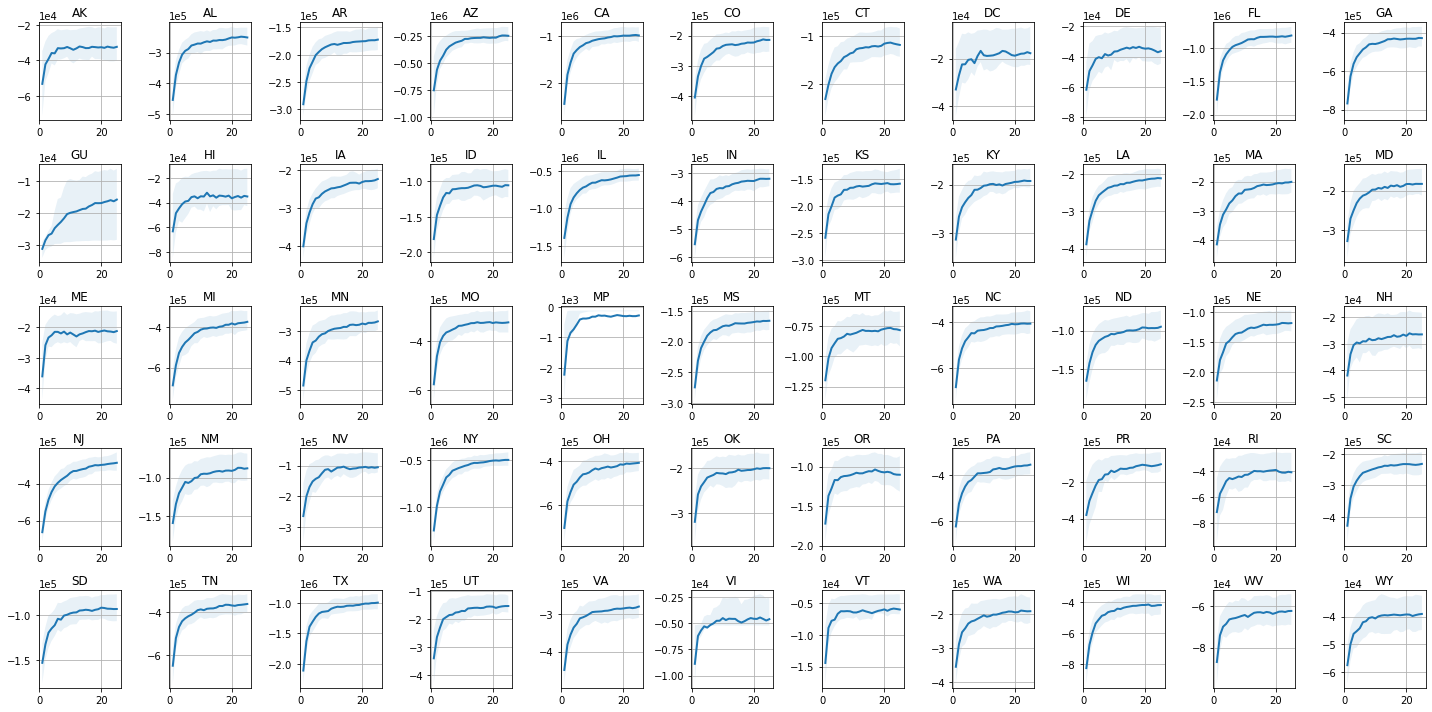

In [116]:
fig, axes = plt.subplots(5,11, figsize=(20,10), facecolor='white')#, sharey=True)

for i, ax in enumerate(axes.flat):
    sn = postL['USPS'].unique()[i]
    st = postL[postL['USPS'] == sn].pivot(index='sim', columns='slot', values='ll')
    #ax.plot(st, lw = .5)
    ax.fill_between(st.index, st.quantile(.25, axis = 1), st.quantile(.75, axis = 1), alpha = .1)
    ax.plot(st.mean(axis =1 ), lw = 2)#, marker = '.')
    ax.set_title(sn)
    ax.grid()
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    #ax.set_ylim(-400000,0)
    #ax.set_xlim(10,25)
fig.tight_layout()

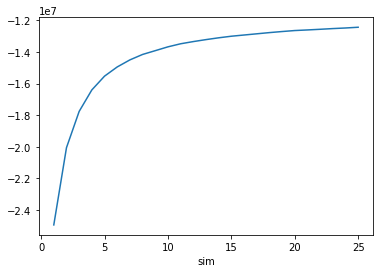

In [140]:
full = postL.groupby(['sim', 'slot']).sum().reset_index()

full.pivot(index='sim', columns='slot', values='ll').mean(axis=1).plot(legend=False)

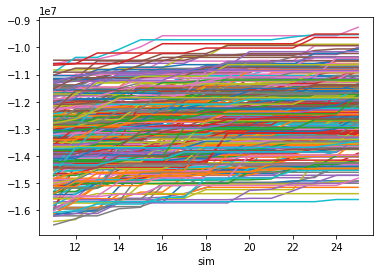

In [141]:
full.pivot(index='sim', columns='slot', values='ll')[10:25].plot(legend=False)

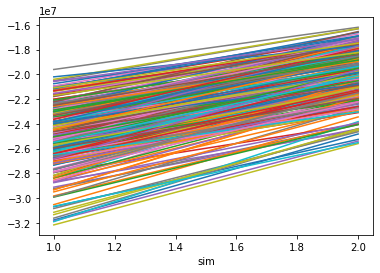

In [142]:
full.pivot(index='sim', columns='slot', values='ll')[0:2].plot(legend=False)

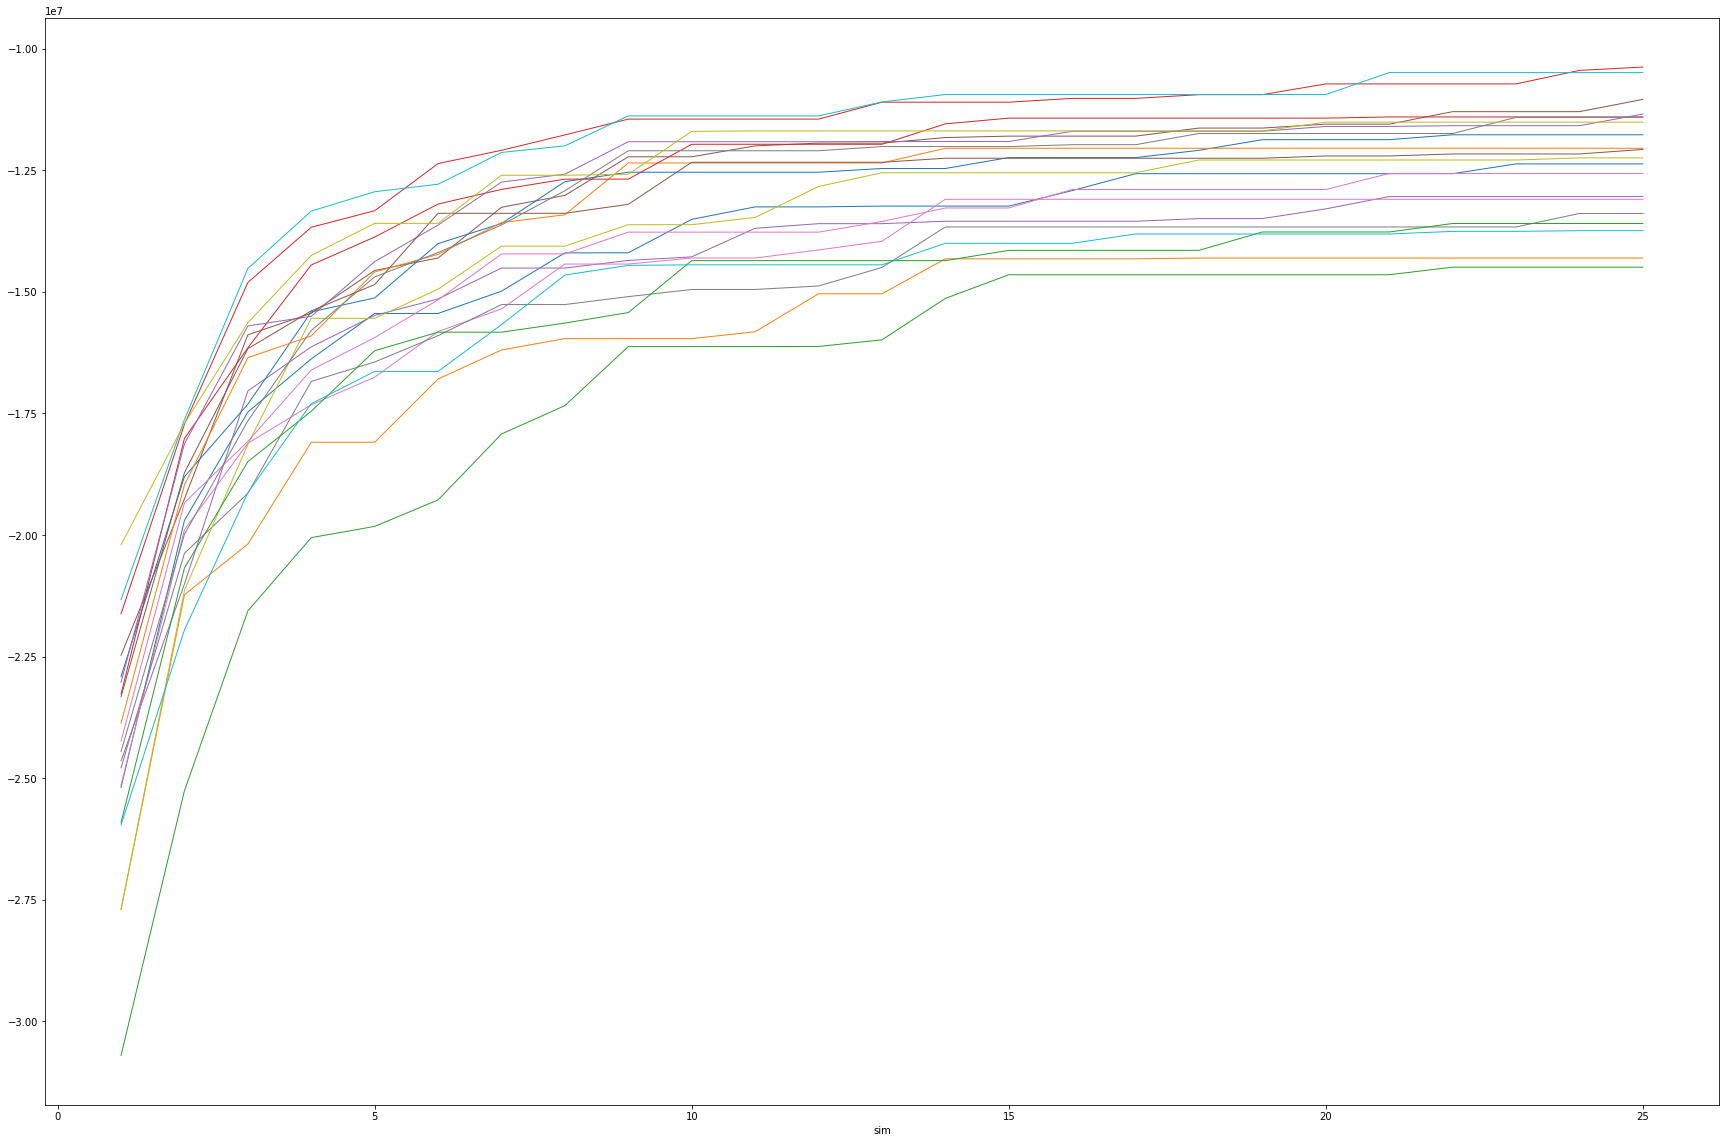

In [148]:
full.pivot(index='sim', columns='slot', values='ll').iloc[:,::15].plot(legend=False,linewidth = 1, figsize=(30,20))
#full.pivot(index='sim', columns='slot', values='ll').mean(axis=1)[10:25].plot(legend=False)

In [16]:
states = ['AK', 'AZ','SD', 'WI']

In [72]:
def read_and_label_llik_st(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['USPS'] = st
    df_csv.groupby(['slot','sim']).sum().reset_index()
    df_csv = df_csv[['ll','sim', 'slot', 'USPS']]
    return df_csv

max_f = -1

resultST = {}

for st in states:
    print(st)
    path = f'state_analysis/{st}'
    file_list = glob.glob(path + "/*.parquet")
    file_list.sort()
    file_list = file_list[:max_f]
    # create a list of functions ready to return a pandas.DataFrame
    dfs = [delayed(read_and_label_llik_st)(fname, st) for fname in file_list]
    # using delayed, assemble the pandas.DataFrames into a dask.DataFrame
    ddfST = dd.from_delayed(dfs)
    
    postST = ddfST.groupby(['sim','slot','USPS']).sum().compute(scheduler="threads")
    postST =  postST.reorder_levels(['USPS','slot','sim']).sort_index().reset_index()
    resultST[st] = postST

AK
AZ
SD
WI


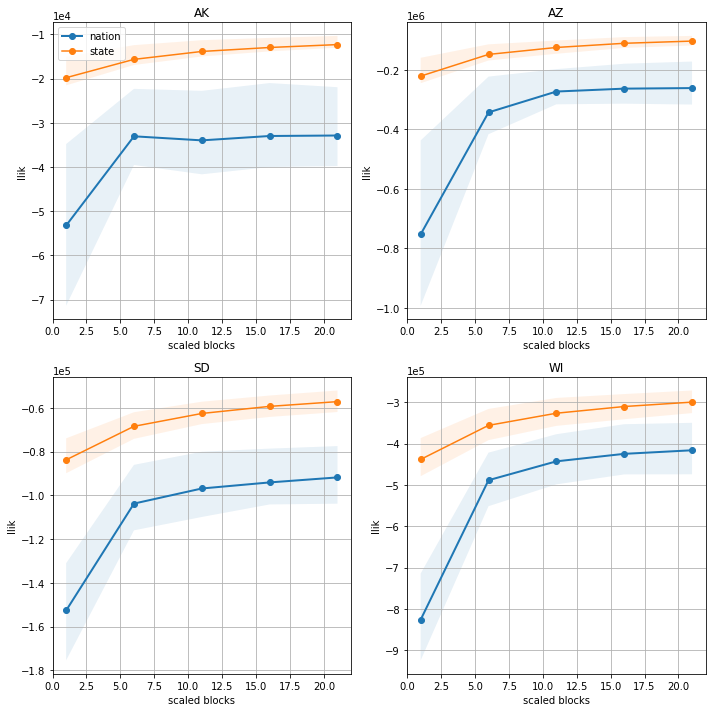

In [177]:
fig, axes = plt.subplots(2,2, figsize=(10,10), facecolor='white')

for i, ax in enumerate(axes.flat):
    sn = states[i]
    st = postL[postL['USPS'] == sn].pivot(index='sim', columns='slot', values='ll')[::5]

    ax.fill_between(st.index, st.quantile(.25, axis = 1), st.quantile(.75, axis = 1), alpha = .1)
    ax.plot(st.mean(axis = 1 ), lw = 2, marker = 'o', label = 'nation')
    ax.set_title(sn)
    ax.grid()
    #ax.set_xlim(6,22)
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    #ax.set_xlim(0,25)
    ax.set_xlabel('scaled blocks')
    ax.set_ylabel('llik')
    
    
    full = resultST[sn].groupby(['sim', 'slot']).sum().reset_index()
    full = full.pivot(index='sim', columns='slot', values='ll')
    scale = st.index#np.arange(5,30,5)
    ax.fill_between(scale, full.quantile(.25, axis = 1), full.quantile(.75, axis = 1), alpha = .1)
    ax.plot(scale, full.mean(axis=1), marker = 'o', label = 'state')
    if i==0:
        ax.legend()
    


fig.tight_layout()


In [1]:
comp = 'S'
def read_and_label_seir_st(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv = df_csv[df_csv['comp']==comp].set_index('time', drop=True).drop('comp',axis = 1).sum(axis=1)
    df_csv = pd.DataFrame(df_csv)
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    return df_csv

In [9]:
path = f'state_analysis/SDseirOther'
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]
sn = 'SD'
# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_seir_st)(fname, sn) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfSE = dd.from_delayed(dfs)

In [10]:
postSE = ddfSE.compute(scheduler="threads")

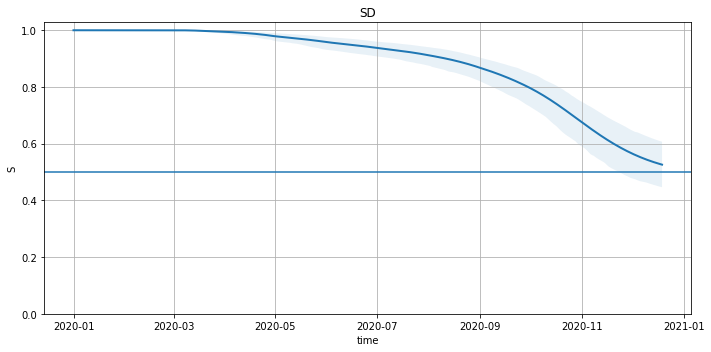

In [12]:
fig, axes = plt.subplots(1,1, figsize=(10,5), facecolor='white')

ax = axes
st = postSE.pivot(columns='slot', values=0)
st = st/max(st[1])

ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .1)
ax.plot(st.mean(axis = 1 ), lw = 2,  label = 'nation')
ax.set_title(sn)
ax.axhline(.50)

ax.grid()
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.set_ylim(0)
ax.set_xlabel('time')
ax.set_ylabel(comp)
    
fig.tight_layout()